2025-09-29 23:37:37.107429: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-29 23:37:37.107579: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-29 23:37:37.107589: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-29 23:37:37.107752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-29 23:37:37.107763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Local CNN model loaded
Local model expected input shape: (None, 20, 1)


Device set to use mps:0


Pretrained HuggingFace model loaded
Loaded 544 real and 544 fake files for testing.


2025-09-29 23:37:41.624618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/miniconda3/envs/hf_audio/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 Metrics Comparison:
Local Model: Precision=0.00, Recall=0.00, F1=0.00, Accuracy=0.50
Pretrained Model: Precision=0.72, Recall=0.86, F1=0.79, Accuracy=0.77


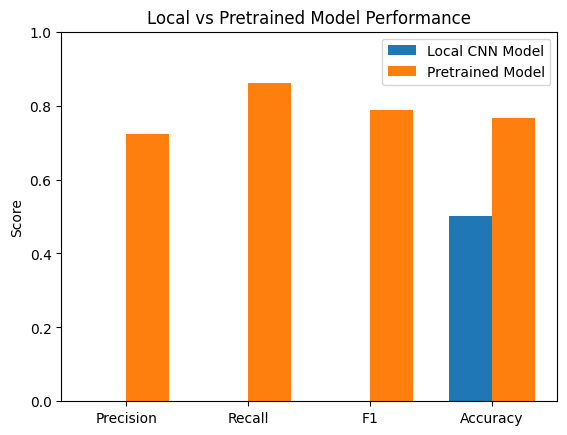

Pretrained Hugging Face Model performs better overall.


In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import load_model
from transformers import pipeline

# Load Local CNN Model 
local_model = load_model("/Users/hudakhaleel/sentinelai/sentinelai/deepfake_audio_cnn3.h5")
print("Local CNN model loaded")
print("Local model expected input shape:", local_model.input_shape)

def predict_local(audio_path, model):
    """Predict with local CNN .h5 model (input shape: (None, 20, 1))"""
    y, sr = librosa.load(audio_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)   # 20 MFCCs to match training
    mfcc = np.mean(mfcc.T, axis=0)                       # (20,)
    mfcc = mfcc.reshape(1, 20, 1)                        # (1, 20, 1) for CNN

    probs = model.predict(mfcc, verbose=0)[0]            # probabilities
    classes = ["Fake", "Real"]                           # adjust if swapped in training
    label = np.argmax(probs)
    confidence = float(np.max(probs))
    return 1 if label == 1 else 0, confidence            # 1 = Real, 0 = Fake

#  Load Pretrained HuggingFace Model 
pretrained_model = pipeline(
    "audio-classification",
    model="Gustking/wav2vec2-large-xlsr-deepfake-audio-classification",
    framework="pt"   # force PyTorch backend
)
print("Pretrained HuggingFace model loaded")

def predict_pretrained(audio_path, model):
    """Predict with pretrained Hugging Face model"""
    try:
        result = model(audio_path, top_k=1)[0]
        label = 1 if result['label'].lower() == "real" else 0
        confidence = float(result['score'])
        return label, confidence
    except Exception as e:
        print(f"Error with {audio_path}: {e}")
        return 0, 0.0

#  Load Test Dataset 
data_dir = "/Users/hudakhaleel/Downloads/archive/for-2sec/for-2seconds/testing"
real_dir = os.path.join(data_dir, "real")
fake_dir = os.path.join(data_dir, "fake")

real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(".wav")]
fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith(".wav")]

all_files = real_files + fake_files
true_labels = [1]*len(real_files) + [0]*len(fake_files)  # 1=Real, 0=Fake

print(f"Loaded {len(real_files)} real and {len(fake_files)} fake files for testing.")

#  Run Predictions 
y_pred_local, conf_local = zip(*[predict_local(f, local_model) for f in all_files])
y_pred_pretrained, conf_pretrained = zip(*[predict_pretrained(f, pretrained_model) for f in all_files])

#  Calculate Metrics 
metrics = {
    "Local Model": {
        "precision": precision_score(true_labels, y_pred_local),
        "recall": recall_score(true_labels, y_pred_local),
        "f1": f1_score(true_labels, y_pred_local),
        "accuracy": accuracy_score(true_labels, y_pred_local)
    },
    "Pretrained Model": {
        "precision": precision_score(true_labels, y_pred_pretrained),
        "recall": recall_score(true_labels, y_pred_pretrained),
        "f1": f1_score(true_labels, y_pred_pretrained),
        "accuracy": accuracy_score(true_labels, y_pred_pretrained)
    }
}

print("\n Metrics Comparison:")
for model_name, vals in metrics.items():
    print(f"{model_name}: Precision={vals['precision']:.2f}, Recall={vals['recall']:.2f}, "
          f"F1={vals['f1']:.2f}, Accuracy={vals['accuracy']:.2f}")

#  Plot Bar Chart 
labels = ["Precision", "Recall", "F1", "Accuracy"]
local_scores = [metrics["Local Model"]["precision"], metrics["Local Model"]["recall"],
                metrics["Local Model"]["f1"], metrics["Local Model"]["accuracy"]]
pretrained_scores = [metrics["Pretrained Model"]["precision"], metrics["Pretrained Model"]["recall"],
                     metrics["Pretrained Model"]["f1"], metrics["Pretrained Model"]["accuracy"]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, local_scores, width, label="Local CNN Model")
rects2 = ax.bar(x + width/2, pretrained_scores, width, label="Pretrained Model")

ax.set_ylabel("Score")
ax.set_title("Local vs Pretrained Model Performance")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0, 1)
plt.show()

#  Choose Best 
if metrics["Local Model"]["f1"] > metrics["Pretrained Model"]["f1"]:
    print(" Local CNN Model performs better overall.")
else:
    print("Pretrained Hugging Face Model performs better overall.")


In [2]:
import os

# Example: point this to your test set
data_dir = "/Users/hudakhaleel/Downloads/archive/for-2sec/for-2seconds/testing"

# Collect all .wav files
all_files = [os.path.join(root, f) 
             for root, _, files in os.walk(data_dir) 
             for f in files if f.endswith(".wav")]

print(f"Loaded {len(all_files)} files for checking predictions.")


Loaded 1088 files for checking predictions.


In [3]:
import librosa
import numpy as np

def extract_mfcc(audio_path, n_mfcc=20):
    y, sr = librosa.load(audio_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = np.mean(mfcc.T, axis=0)  # average over time
    return mfcc.reshape(1, -1)


In [5]:
from tensorflow.keras.models import load_model
# Load Local CNN Model 
local_model = load_model("/Users/hudakhaleel/sentinelai/sentinelai/deepfake_audio_cnn2.h5")
print("Local CNN model loaded")

local_model.summary()
# Check predictions on a few files
for f in all_files[:5]:
    x = extract_mfcc(f)
    preds = local_model.predict(x)
    print(f"{os.path.basename(f)} → {preds}")



2025-09-29 23:21:46.271459: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-29 23:21:46.271586: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-29 23:21:46.271593: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-29 23:21:46.271857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-29 23:21:46.271870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Local CNN model loaded


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 18, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,755 (73.27 KB)

 Trainable params: 18,753 (73.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
file1342.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav → [[0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2025-09-29 23:21:46.787993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


file1654.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav → [[0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
file1297.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav → [[6.883342e-29]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
file1781.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav → [[7.790989e-36]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
file960.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav → [[1.4941872e-27]]
